In [13]:
# check available gpus
# !nvidia-smi

In [14]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [15]:
from external.loss_utils import PerceptualTextureLoss, tv_loss 
from modules.basic_utils import read_image, lazy_plot
from modules.utils import get_texture_map

In [16]:
# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image

verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [17]:
image_resolution = 256#128#256 # 512

In [18]:
# torch.nn.Parameter import it 
from torch.nn import Parameter

# image_resolution =256

In [19]:
renderer = Renderer(image_resolution=image_resolution,device=device,blur_radius=0.0)
renderer.load_inputs(verts_T_paths,tm_paths = tm_paths,
                     euler_list = euler_list,require_grad=False)
# images = renderer.render()
# renderer.texture_map.shape # [1,1024,1024,3]
# renderer.show()

In [20]:
# cuda memory error. remove cache
# del renderer
torch.cuda.empty_cache()

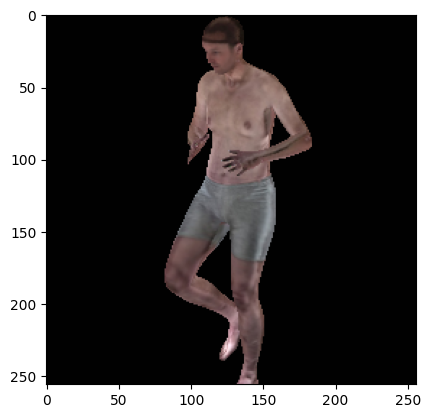

In [21]:
renderer.show()

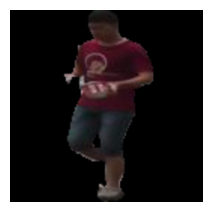

(1, 256, 256, 3)


In [22]:
tgt = remove_background(image_path,seg_mask_path)
# lazy_plot(tgt)
tgt = squared_image(tgt)
# print(tgt.shape)
# lazy_plot(tgt)
from skimage.transform import resize 
tgt = resize(tgt,[image_resolution,image_resolution,3])[None,...] # ndarray 
lazy_plot(tgt)
print(tgt.shape)

In [23]:

texture_loss = PerceptualTextureLoss()

# create texture flow 
texture_flow = torch.rand(1, 1024, 1024, 2)*2 -1
texture_flow.requires_grad = True
# texture_flow = torch.nn.Parameter(texture_flow)


tgt_pre = torch.Tensor(tgt).permute(0,3,1,2) # [1,3,256,256]
tgt_post = tgt * 255.0
# tgt_post.requires_grad = True
tgt.shape


Setting up Perceptual loss..
Done


(1, 256, 256, 3)

i : 0 loss: 10.015326499938965


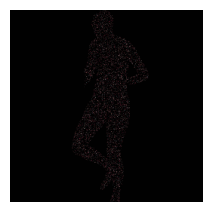

loss: 10.015326499938965
i : 1 loss: 9.475093841552734
i : 2 loss: 9.062785148620605
i : 3 loss: 8.739420890808105
i : 4 loss: 8.479020118713379
i : 5 loss: 8.259075164794922
i : 6 loss: 8.05810546875
i : 7 loss: 7.87551736831665
i : 8 loss: 7.69891357421875
i : 9 loss: 7.543321132659912
i : 10 loss: 7.390454292297363
i : 11 loss: 7.238651752471924
i : 12 loss: 7.0926666259765625
i : 13 loss: 6.956151008605957
i : 14 loss: 6.826350688934326
i : 15 loss: 6.703729629516602
i : 16 loss: 6.577549934387207
i : 17 loss: 6.464616775512695
i : 18 loss: 6.355104923248291
i : 19 loss: 6.245949745178223
i : 20 loss: 6.139015197753906
i : 21 loss: 6.0339884757995605
i : 22 loss: 5.935315132141113
i : 23 loss: 5.839392185211182
i : 24 loss: 5.743740558624268
i : 25 loss: 5.653253555297852
i : 26 loss: 5.5646185874938965
i : 27 loss: 5.4807939529418945
i : 28 loss: 5.401046276092529
i : 29 loss: 5.323415756225586
i : 30 loss: 5.245502948760986
i : 31 loss: 5.169928550720215
i : 32 loss: 5.0942878723

In [24]:
# training loop to learn texture and T from image
params = [ texture_flow]
optim = torch.optim.Adam(params,lr=0.005)


for i in range(100):
    optim.zero_grad()


    # update texture map
    renderer.texture_map = get_texture_map(texture_flow,tgt_post)
    images = renderer.render()

    images = images.permute(0,3,1,2)[:,:3,:,:].float().to(device)

    # resize both to 256,256
    
    
    perceptual_loss = texture_loss(images,tgt_pre.float().to(device))
    tv_loss_value = tv_loss(texture_flow)
    loss = perceptual_loss  + 1 * tv_loss_value

    # just use sme
    loss2 = images - tgt_pre.float().to(device)
    loss2 = torch.sum(loss**2)

    loss = loss2 #+loss
    

    # print(f"percep loss:{perceptual_loss.item()} tv loss:{tv_loss_value.item()}")

    print('i :' , i,'loss:',loss.item())
    # break
    



    # diff = images[0,...,:3] - torch.from_numpy(tgt).to(device)
    # loss = torch.sum(diff**2) + 0.5 * tv_loss(renderer.texture_map)
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%200 == 0:
        lazy_plot(images)
        # plt.figure(figsize=(3,3))
        # plt.imshow(images[0,...,:3].cpu().detach().numpy().clip(0,1))
        # plt.axis('off')
        # plt.show()
        
        # print(renderer.T)
        # print(renderer.texture_map)
        # print(renderer.verts)
        print('loss:',loss.item())
 


In [25]:
# save texture
# plt.imsave("data/exp/tm_percep_tv.jpg",renderer.texture_map.cpu().detach().numpy().clip(0,1))

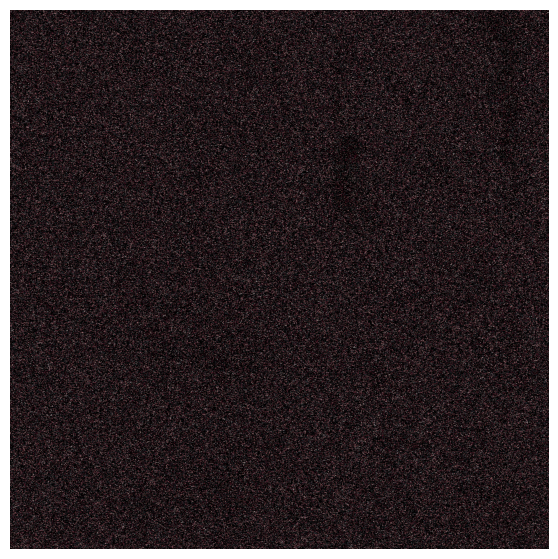

In [26]:
# renderer.texture_map
lazy_plot(renderer.texture_map,figsize=(7,7))

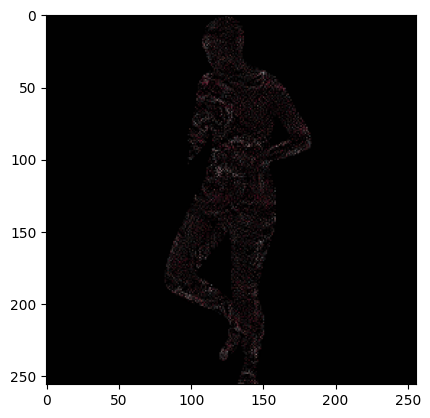

In [27]:
renderer.show()

In [28]:
get_texture_map(texture_flow,tgt_post).max()


tensor(196.2103, grad_fn=<MaxBackward1>)

In [29]:
tgt_post.max()

196.375